# Case Study:

## Tahoe Healthcare Systems HRRP Improvement.

### Bahman Roostaei
** March 2017. **

** The ultimate goal of this project is to find a data driven model which can predict the 30-day readmission chance of patients and by that recommend whether to use any provisions such as CareTracker and give an estimate of savings by lowering the HRRP penalties. Any prediction model would have certain accuracy. In the context of the readmission cost accuracy, predicting the readmission of a patient correctly would result in savings. We will present an estimate of savings for each model using the accuracy as metric based on the given cost of unplanned readmission penalty (~ 8000 USD per patient), careTracker cost (~ 1200 USD per patient) and finally the careTracker success rate (~ 40%). Also before diving into modeling we try to give insights into the data by providing some visualizations. Hopefully this will provide better understanding of the readmission causes of the patients. **

In [90]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [1]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegressionCV

In [3]:
df = pd.read_csv('Tahoe_Data_Case.csv')

In [4]:
df.head(10)

,﻿age,female,flu_season,ed_admit,severity score,comorbidity score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0
5,80,1,0,1,29,172,0
6,71,1,0,1,31,271,1
7,72,0,0,0,47,221,1
8,69,1,0,1,44,193,0
9,65,1,0,0,10,130,0


** The data provided by Tahoe Healthcare Systems includes 4382 records with following features: **

In [83]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4382 entries, 0 to 4381
Data columns (total 7 columns):
﻿age                 4382 non-null int64
female               4382 non-null int64
flu_season           4382 non-null int64
ed_admit             4382 non-null int64
severity score       4382 non-null int64
comorbidity score    4382 non-null int64
readmit30            4382 non-null int64
dtypes: int64(7)
memory usage: 239.7 KB


** Data are clean. **

In [84]:
# size of data:
df.shape[0]

4382

** According to data current readmission rate is about 2.28% higher than national average of readmission rate ( which is 20%): **

In [8]:
df['readmit30'].sum()/df['readmit30'].count()

0.22774988589685075

** The data shows some imbalance: **

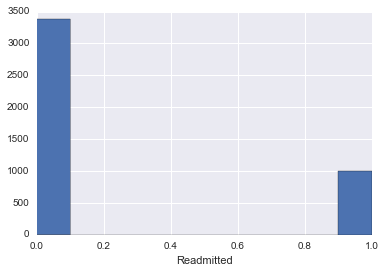

In [133]:
df['readmit30'].hist();
plt.xlabel('Readmitted');

** We will (see below) randomly oversample the minority class to build our model. However before that we hold a test sample from the data in order to evaluate our model: **

** most of the patients are in the category of non-severe cases: **

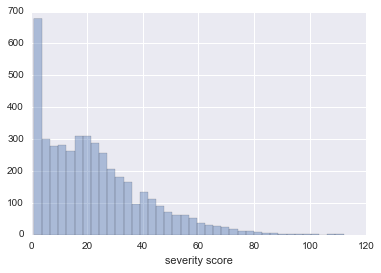

In [10]:
sns.distplot(df['severity score'],kde=False);

 ** most of the patients are also in the category of having some diagnosed pre-existing condition (but not high): **

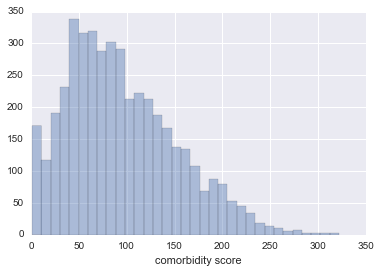

In [11]:
sns.distplot(df['comorbidity score'],kde=False);

** Data is provided only for age of 65 and older: **

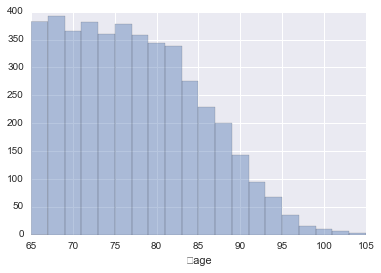

In [121]:
#'\ufeffage' = 'age'
sns.distplot(df['\ufeffage'],kde=False,bins=20);

** patient's gender is almost equally distributed: **

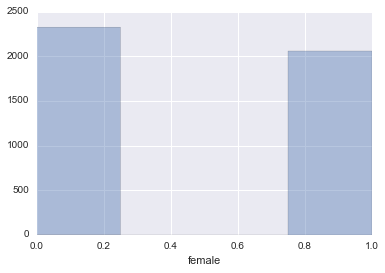

In [13]:
sns.distplot(df['female'],kde=False,bins=4);

** Very naive estimate of the savings if careTracker had been used:  **

** total loss for the readmitted: **

In [102]:
n_readmit = df[df['readmit30'] == 1]['readmit30'].sum()
print('number of readmitted=',n_readmitt)

number of readmitted= 998


In [101]:
penalty_readmit = 8000

In [103]:
total_loss = n_readmit*penalty_readmit
print('total_loss without any action:',total_loss)

total_loss without any action: 7984000


** CareTracker cost for readmitted patients: **

In [104]:
tracker_cost = 1200

In [106]:
CT_cost = n_readmit*tracker_cost
print('total cost of care tracker for readmitted patients:',CT_cost)

total cost of care tracker for readmitted patients: 1197600


** savings as a result of CareTracker: **

In [107]:
# CareTracker success rate:
r_CT = 0.4

In [108]:
sav_CT = n_readmit*r_CT*penalty_readmit
print('total savings if CareTracker used for readmitted:',sav_CT)

total savings if CareTracker used for readmitted: 3193600.0000000005


In [109]:
print('total cost if the CareTracker used for readmitted patients:')
total_loss + CT_cost - sav_CT

total cost if the CareTracker used for readmitted patients:


5988000.0

In [110]:
blind_CT_cost = df.shape[0]*1200
print('total cost of CareTracker if used blindly for all patients:',blind_CT_cost)

total cost of CareTracker if used blindly for all patients: 5258400


In [112]:
print('total cost if the CareTracker used blindly for all patients:')
total_loss + blind_CT_cost - sav_CT

total cost if the CareTracker used blindly for all patients:


10048800.0

** In order to provide furthur insight into data it is important to note the features of the patients seeking treatment at Tahoe Healthcare Systems: **

** There is a positive correlation between age and comorbidity score. The sample indicates the population of mid-age (around 75) have less comorbidity:  **

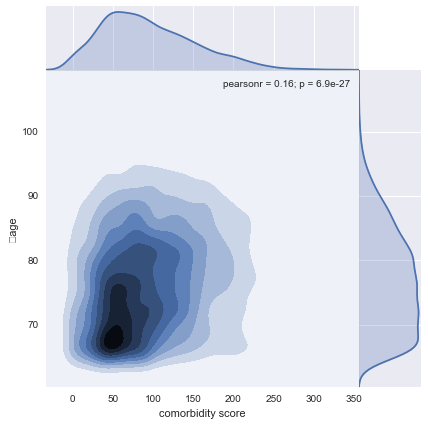

In [66]:
sns.jointplot(x='comorbidity score',y='\ufeffage',kind="kde", space=0,data=df);

** Patient's severity of their condition is also positively correlated with the patient's age: **

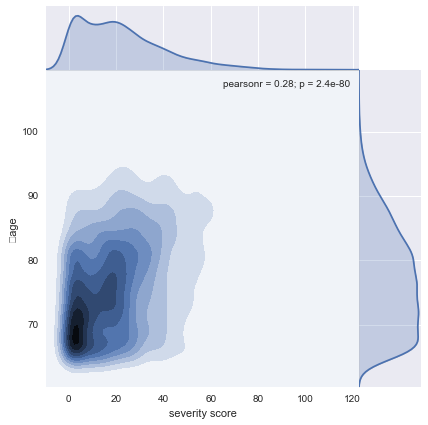

In [114]:
sns.jointplot(x='severity score',y='\ufeffage'#age
              ,kind="kde", space=0,data=df);

** Data provides us with environmental factor (flu season) as well. Data however does not indicate significant evidence for difference in readmission rate between the two genders. However in flu season more readmission cases is seen: **

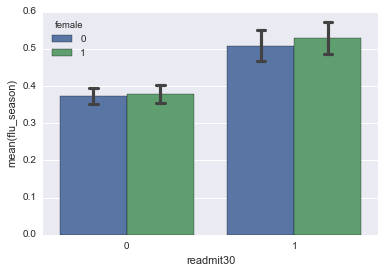

In [76]:
sns.barplot(x="readmit30",y="flu_season", hue="female", data=df,capsize=0.05);

** flu season appears to have not affected the comorbidity score effect on the readmission: **

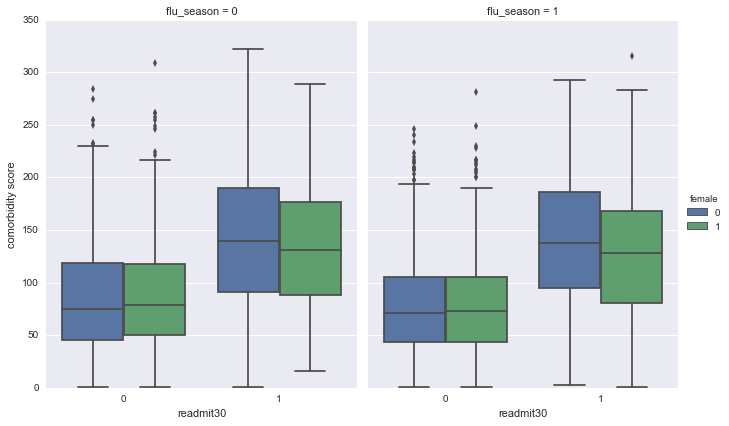

In [82]:
sns.factorplot(x="readmit30", y="comorbidity score", hue="female",
               col="flu_season", data=df, kind="box", size=6, aspect=.8);

** In order to provide a model we first examine the score of random forest model for the data without regards to the imbalance. The random forest is appropriate here because it is a fast algorithm for the data set size that we currently have and most importantly this algorithms does not overfit based on the fact that it is an ensembling model. **

In [14]:
clf = RandomForestClassifier(n_estimators=10, max_depth=None,min_samples_split=2, random_state=0)

In [15]:
X = df.drop('readmit30',axis=1)
y = df['readmit30']

In [16]:
scores = cross_val_score(clf, X, y)

** mean cross validation score on raw data: **

In [17]:
scores.mean()

0.77110911085482836

** Let's hold out a test set in order to deal with the imbalance issue in the training set: **

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [37]:
y_test = list(y_test)

** now we oversample the minority class: **

In [19]:
ros = RandomOverSampler(random_state=42)

In [20]:
X_res, y_res = ros.fit_sample(X_train, y_train)

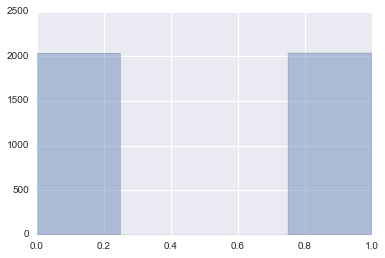

In [21]:
sns.distplot(y_res,kde=False,bins=4);

In [22]:
clf_res = RandomForestClassifier(n_estimators=100, max_depth=None,min_samples_split=2, random_state=0)

In [23]:
clf_res.fit(X_res,y_res)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
            verbose=0, warm_start=False)

In [24]:
y_pred = clf_res.predict(X_test)

In [38]:
tp = [1 for i in range(len(y_pred)) if y_pred[i] == y_test[i] and y_test[i] == 1]

In [39]:
tn = [1 for i in range(len(y_pred)) if y_pred[i] == y_test[i] and y_test[i] == 0]

In [40]:
accuracy=(sum(tp)+sum(tn))/len(y_pred)
print('Random Forest Model Accuracy=',accuracy)

Random Forest Model Accuracy= 0.764403879064


 ** Based on this model there is 76% chance that we make correct prediction about the patient's readmission. In this case if the hospital decides to use a service such as CareTracker for the patients predicted to be readmitted then the total cost per readmitted patient will be reduced to: **

In [115]:
# (penalty cost because of readmission) - (savings because of the model prediction combined with the 
# cost of CareTracker):
penalty_readmit - 0.76*r_CT*(penalty_readmit - tracker_cost) 

5932.799999999999

In [116]:
(0.76*r_CT*(penalty_readmit - tracker_cost))/penalty_readmit

0.2584

** which is 25.8% reduction in costs. **

** Now let's find out how the random forest has sorted the importance of the features: **

In [43]:
ind = clf_res.feature_importances_.argsort()

** Based on the random forest model the feature importance is as follows: **

In [45]:
for i in ind:
    print(df.columns[i],':',clf_res.feature_importances_[i])

ed_admit : 0.018360248318
female : 0.0269393411241
flu_season : 0.0333696888447
﻿age : 0.211395875425
severity score : 0.272698665032
comorbidity score : 0.437236181256


** Now we try another model, the GBoost classifier to find out if there is any improvement by using a different algorithm. GBoost, since it has an inherent correction mechanism by elevating the errors, may be very appropriate. Although slower than random forest, we do not expect the speed to be an issue for a data set  as large as what we have: **

In [49]:
# using default parameters:
clf_gb = GradientBoostingClassifier()

In [51]:
clf_gb.fit(X_res,y_res)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False)

In [52]:
y_pred = clf_gb.predict(X_test)

In [53]:
tp = [1 for i in range(len(y_pred)) if y_pred[i] == y_test[i] and y_test[i] == 1]

In [54]:
tn = [1 for i in range(len(y_pred)) if y_pred[i] == y_test[i] and y_test[i] == 0]

In [55]:
scores_gb = cross_val_score(clf_gb, X, y)

In [56]:
scores_gb.mean()

0.79393078488181301

In [57]:
accuracy=(sum(tp)+sum(tn))/len(y_pred)
print('GBoost Accuracy=',accuracy)

GBoost Accuracy= 0.726754135767


** GBoost in fact is not as accurate as random forest is. **

** However GBoost has the same feature importance result as random forest: **

In [59]:
for i in ind:
    print(df.columns[i],':',clf_res.feature_importances_[i])

ed_admit : 0.018360248318
female : 0.0269393411241
flu_season : 0.0333696888447
﻿age : 0.211395875425
severity score : 0.272698665032
comorbidity score : 0.437236181256


## Conclusion:

** By using random forest model, a decision tree ensembling method we are able to predict 76% of the time, whether a patient will be readmitted or not based on the criteria the Tahoe Halthcare Systems has given to us. With this accuracy we recommend the healthcare provider to offer extra services to the patients to be predicted readmission such as CareTracker. Given the high penalty of 8000 USD predicted for readmission, this will certainly help the provider in less cost of patient care and less HRRP penalties. **

** The data driven model presented here may be improved by follwoing methods: **

1- Clustering of the patients without regards to their readmission (using for example K-means). Assuming the clustering is successful, a random forest or some linear model may be applied to each cluseter. This way the model prediction may be improved.

2- A feature re-grouping method, based on the patient features in the dataset may help the algorithms to better make decisions. This is a supervised version of number (1) above.

3- Most importantly: a better provision to be offered to the patients who are likely to be readmitted. 